In [ ]:
    # 1. Collect two datasets
    # 2. Generate candidate mean activations for each(for each token position, and for every layer, across each data point)
    # 3. Generate candidate vectors 1/dataset_size*(difference between harmful and harmless prompt for every layer that is num_hidden_layers, positions long, and dimensions of model, 4d tensor)
    # 4. choose the best vector through the algorithm (doesn't have high KL divergene)
    # 5. Ablate vector and test rate of refusal bypass on harmful prompts
    # 6. Add vector and test rate of induced refusals on harmless prompts


In [ ]:
import torch
import contextlib
from typing import Callable, Iterable, Optional, List

from torch import Tensor
from tqdm import tqdm
import requests

from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
def load_tinyllama():
    tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    base_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    model = PeftModel.from_pretrained(base_model, "uchicago-xlab-ai-security/refuse_harmful_v2")
    model.requires_grad_(False) 
    return model, tokenizer

In [ ]:
model, tokenizer = load_tinyllama()

In [15]:
block_modules = model.base_model.model.model.layers
n_layers = len(block_modules)
print(n_layers)

22


In [ ]:
# template from https://ollama.com/library/tinyllama:1.1b/blobs/af0ddbdaaa26

SYSTEM_PROMPT = "You are a helpful AI assistant."
CHAT_TEMPLATE = (
    "<|system|>\n" + SYSTEM_PROMPT + "</s>\n"
    "<|user|>\n{instruction}</s>\n"
    "<|assistant|>"
)

eoi_toks = tokenizer.encode(CHAT_TEMPLATE.split("{instruction}")[-1], add_special_tokens=False)
positions = list(range(-len(eoi_toks), 0))   # all post-instruction tokens; or positions=[-1]

def tokenize_instructions_fn(instructions):
    prompts = [CHAT_TEMPLATE.format(instruction=s) for s in instructions]
    return tokenizer(prompts, padding=True, truncation=True, max_length=512, return_tensors="pt")


The authors only look at post-instruction tokens in the foward pass, which are constant over all samples in the dataset

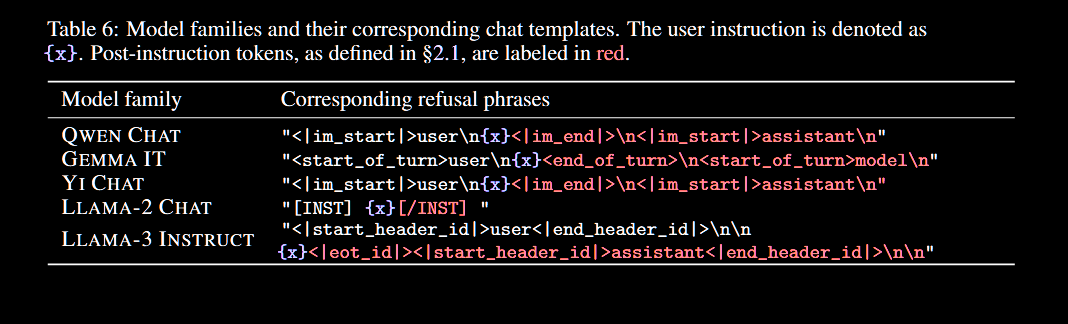

This is to avoid unnecessary variance that would be incurred when considering model-generated tokens, ensuring that the vector directions are only a property of the.

In [ ]:
print(eoi_toks)
print(tokenizer.decode(eoi_toks))


[2, 29871, 13, 29966, 29989, 465, 22137, 29989, 29958]
</s> 
<|assistant|>


Ideally, first, we would filter the datasets to ensure that the helpful/harmless split corresponds to which prompts the model is actually refusing.  

In [ ]:
def get_dataset_split(harmtype: str, split: str,):   
    assert harmtype in ['harmless', 'harmful']
    assert split in ['train', 'val', 'test']
    url = f"https://github.com/andyrdt/refusal_direction/blob/main/dataset/splits/{harmtype}_{split}.json"
    response = requests.get(url)
    dataset = response.json

    dataset = [d['instruction'] for d in dataset]

    return dataset

In [ ]:
def tokenize_instructions(
    tokenizer: AutoTokenizer,
    instructions: List[str]
) -> Tensor:
    """Tokenize instructions using tokenizer's chat template"""
    
    conversations = [[{"role": "user", "content": instruction}] for instruction in instructions]
    
    prompts = [
        tokenizer.apply_chat_template(conv, tokenize=False, add_generation_prompt=False)
        for conv in conversations
    ]
    
    return tokenizer(prompts, padding=True, truncation=False, return_tensors="pt").input_ids

The residual stream at every layer and all post-instruction token is averaged across all prompts in the dataset and stored

In [ ]:
@contextlib.contextmanager
def add_hooks(module_forward_pre_hooks, module_forward_hooks):
    handles = []
    try:
        for mod, fn in module_forward_pre_hooks:
            handles.append(mod.register_forward_pre_hook(fn, with_kwargs=False))
        for mod, fn in module_forward_hooks:
            handles.append(mod.register_forward_hook(fn, with_kwargs=False))
        yield
    finally:
        for h in handles: h.remove()

def get_mean_activations_pre_hook(layer, cache, n_samples, positions):
    def hook_fn(module, inputs):
        h = inputs[0].to(cache.dtype)                # (batch, seq_length, d_model)
        cache[:, layer] += (h[:, positions, :].sum(dim=0) / n_samples)
        # add d_model size vector summed across the batch 
    return hook_fn

def get_mean_activations(model, instructions, batch_size=32, positions=[-1]):
    n_pos = len(positions)
    d_model = model.config.hidden_size
    n_layers = model.config.num_hidden_layers
    n_samples = len(instructions)

    cache = torch.zeros((n_pos, n_layers, d_model), dtype=torch.float64, device=model.device)
    pre_hooks = [(block_modules[i], get_mean_activations_pre_hook(i, cache, n_samples, positions))
                 for i in range(n_layers)]
    # passes in a (module, module-specific-hook) tuple for each layer

    with torch.inference_mode():
        for i in tqdm(range(0, n_samples, batch_size)):
            batch = tokenize_instructions_fn(instructions[i:i+batch_size])
            with add_hooks(pre_hooks, []):
                model(input_ids=batch.input_ids.to(model.device),
                      attention_mask=batch.attention_mask.to(model.device))
    return cache

def get_mean_diff(model, harmful_instructions, harmless_instructions, positions=[-1], batch_size=32):
    mean_harmful = get_mean_activations(model, harmful_instructions,  batch_size=batch_size, positions=positions)
    mean_harmless = get_mean_activations(model, harmless_instructions, batch_size=batch_size, positions=positions)

    return mean_harmful - mean_harmless


In [ ]:
harmful_train = get_dataset_split("harmful", "train")
harmless_train = get_dataset_split("harmless", "train") 

mean_diffs = get_mean_diff(model, harmful_instructions=harmful_train, harmless_instructions=harmless_train, positions=positions)
# we defined the positions that are being passed in earlier

assert mean_diffs.shape == (len(eoi_toks), model.config.num_hidden_layers, model.config.hidden_size)
assert not mean_diffs.isnan().any()

torch.save(mean_diffs, "mean_diffs_v1.pt")

In [ ]:
# TODO: note on how refusals are evaluated? Not exactly that important, but they use the fact that refusals have very similar/predictable first tokens and you can just test if the first token is "I"

To chose the best refusal direction out of all of the layers and token positions, the authors test each of the $I * L$ refusal vectors ($I$ being the number of post-instruction tokens and $L$ being the number of layers) and choose the vector that, when ablated, induces the most non-refusal on harmful activations satisfying these conditions:
1. Adding the vector should induce refusal on harmless prompts (the direction is sufficient to induce refusal)
2. Ablating the vector on harmless prompts should result in similar probability distributions for the next token, measured through KL divergence (the direction preserves model behavior / coherency)
3. The layer is less than $0.8L$, or the direction was taken from a hidden state first 80% of the model's layers. This is to prevent the direction selection process from choosing directions closer to the unembedding matrices, to choose a directon that represents some higher-level as opposed to token-level feature.

In [ ]:
# TODO: filter for best layer/position, right now we just choose a layor in the middle 

# last position, 10th layer

direction = mean_diffs[-1, 10].to(model.device)            # (d_model,)


In [ ]:
def make_direction_ablation_post_hook(direction: torch.Tensor):
    base_dir = direction / (direction.norm() + 1e-8)

    def hook_fn(module, inputs, output):
        # output can be Tensor or a tuple (hidden_states, *extras)
        def project_out(h: torch.Tensor) -> torch.Tensor:
            dir_vec = base_dir.to(h.dtype).to(h.device)          # (d_model,)
            # h: (batch, seq, d_model); (h @ dir) -> (batch, seq)
            comp = (h @ dir_vec).unsqueeze(-1) * dir_vec         # (batch, seq, d_model)
            # residual stream vector dot normalized direction vector gives (batch, seq)   
            return h - comp

        if isinstance(output, tuple):
            h = output[0]
            return (project_out(h), *output[1:])
        else:
            return project_out(output)

    return hook_fn

In [ ]:
HookFn = Callable[..., object]

# slightly repetitive from previous add_hooks function, but this one adds the same hook to all layers, while the
# add_hooks function above adds a unique hook for each layer (specifying what layer of cache to write to)
@contextlib.contextmanager
def apply_hooks(modules: Iterable[torch.nn.Module],
                pre_hook: Optional[HookFn] = None,
                post_hook: Optional[HookFn] = None):
    """Register pre/post hooks on a set of modules for the duration of the context."""
    handles: List[torch.utils.hooks.RemovableHandle] = []
    try:
        if pre_hook is not None:
            for m in modules:
                handles.append(m.register_forward_pre_hook(pre_hook, with_kwargs=False))
        if post_hook is not None:
            for m in modules:
                handles.append(m.register_forward_hook(post_hook, with_kwargs=False))
        yield
    finally:
        for h in handles:
            h.remove()

@torch.no_grad()
def generate_with_hooks(
    model, tokenizer, prompts: List[str], block_modules: Iterable[torch.nn.Module], *, 
    pre_hook: Optional[HookFn] = None,
    post_hook: Optional[HookFn] = None,
    max_new_tokens: int = 128,
    return_full_text: bool = False,
    **gen_kwargs,
) -> List[str]:
    batch = tokenizer(
        prompts, return_tensors="pt", padding=True, truncation=True, max_length=512
    ).to(model.device)

    def _generate():
        return model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch.get("attention_mask", None),
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            **gen_kwargs,
        )

    with torch.inference_mode():
        if pre_hook is None and post_hook is None:
            out_ids = _generate()
        else:
            with apply_hooks(block_modules, pre_hook=pre_hook, post_hook=post_hook):
                out_ids = _generate()

    if return_full_text:
        return tokenizer.batch_decode(out_ids, skip_special_tokens=True)

    input_lens = batch["attention_mask"].sum(dim=1)
    outs: List[str] = []
    for j in range(out_ids.size(0)):
        cont_ids = out_ids[j, input_lens[j]:]
        outs.append(tokenizer.decode(cont_ids, skip_special_tokens=True))
    return outs

In [ ]:
harmful_test = get_dataset_split("harmful", "test")
harmful_test_formatted = [CHAT_TEMPLATE.format(instruction=s) for s in harmful_test]

baseline_texts = generate_with_hooks(
    model, tokenizer,
    prompts=harmful_test_formatted,
    block_modules=block_modules,
    post_hook=None, 
    pre_hook=None, 
    max_new_tokens=128,
    do_sample=False
)

post_hook = make_direction_ablation_post_hook(direction)  # direction: (d_model,) normalized or not
ablated_texts = generate_with_hooks(
    model, tokenizer,
    prompts=harmful_test_formatted,
    block_modules=block_modules,
    post_hook=post_hook, 
    max_new_tokens=128,
    do_sample=False
)

for i in range(5):
    print(f"instruction: + {harmful_test[i]}\n")
    print(f"baseline response: {baseline_texts[i]}\n")
    print(f"ablated response: {ablated_texts[i]}\n")


In [ ]:
# TODO: activation addition

In [ ]:
# TODO: inference/evaluation pipeline + more examples of completions